In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
import os

# Montar Google Drive
drive.mount('/content/drive')

# Cambiar al directorio donde se encuentra el dataset
dataset_path = '/content/drive/My Drive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos'
os.listdir(dataset_path)  # Verifica los archivos en el directorio

Mounted at /content/drive


['readme.md',
 'Lexique - Data Analyst.xlsx',
 'extract - cash request - data analyst.csv',
 'extract - fees - data analyst - .csv']

In [ ]:
# Cargar el dataset principal de solicitudes de adelanto en efectivo
credit_requests = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - cash request - data analyst.csv')
# Crear una copia del DataFrame para preservar el original
cr = credit_requests.copy()
# Inspeccionar la estructura y el tipo de datos de 'cash_request'
credit_requests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          23970 non-null  int64  
 1   amount                      23970 non-null  float64
 2   status                      23970 non-null  object 
 3   created_at                  23970 non-null  object 
 4   updated_at                  23970 non-null  object 
 5   user_id                     21867 non-null  float64
 6   moderated_at                16035 non-null  object 
 7   deleted_account_id          2104 non-null   float64
 8   reimbursement_date          23970 non-null  object 
 9   cash_request_received_date  16289 non-null  object 
 10  money_back_date             16543 non-null  object 
 11  transfer_type               23970 non-null  object 
 12  send_at                     16641 non-null  object 
 13  recovery_status             333

In [ ]:
# Filtrar columnas relevantes para el análisis
cr = cr[["amount", "created_at", "user_id", "deleted_account_id", "transfer_type"]]
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   amount              23970 non-null  float64
 1   created_at          23970 non-null  object 
 2   user_id             21867 non-null  float64
 3   deleted_account_id  2104 non-null   float64
 4   transfer_type       23970 non-null  object 
dtypes: float64(3), object(2)
memory usage: 936.5+ KB


In [ ]:
# Renombrar 'id' a 'cash_request_id' para mayor claridad (y para el merge posterior con fees)
cr.rename(columns={'id': 'cash_request_id'}, inplace=True)

In [ ]:
# Ver NA en columna 'user_id'
cr[cr['user_id'].notna()].nunique() # 21867 válidos
cr[cr['user_id'].isna()].nunique() # 2103 Nan
# Comprobación: 21867 válidos + 2103 NaN = 23970 filas

# Comprobar que 'user_id' y 'deteled_account_id' son complementarios
cr[cr['user_id'].isna() & cr['deleted_account_id'].isna()] # Empty dataframe -> Siempre tenemos un valor válido en una de las dos columnas

# Comprobar solapamientos
cr[cr['user_id'].notna() & cr['deleted_account_id'].notna()] # La fila crid=280 tiene user_id=3161 y a la vez deleted_account_id=262

In [ ]:
# Nueva columna 'id_completo' a partir de user_id + deleted_account_id
cr['id_completo'] = cr['user_id'].fillna(cr['deleted_account_id'])
# Conversión de float a int
cr['id_completo'] = cr['id_completo'].astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   amount         23970 non-null  float64
 1   created_at     23970 non-null  object 
 2   user_id        23970 non-null  float64
 3   transfer_type  23970 non-null  object 
dtypes: float64(2), object(2)
memory usage: 749.2+ KB


In [ ]:
# Convertir 'created_at' a tipo datetime para manipulación de fechas
cr['created_at'] = pd.to_datetime(cr['created_at'])
cr.head()

,amount,created_at,user_id,transfer_type
0,100.0,2019-12-10 19:05:21.596873+00:00,804.0,regular
1,100.0,2019-12-10 19:50:12.347780+00:00,231.0,regular
2,100.0,2019-12-10 19:13:35.825460+00:00,191.0,regular
3,99.0,2019-12-10 19:16:10.880172+00:00,761.0,regular
4,100.0,2020-05-06 09:59:38.877376+00:00,7686.0,regular


In [ ]:
# Convertir la columna 'created_at' a una fecha sin zona horaria
cr['created_at'] = cr['created_at'].dt.tz_localize(None)
cr.head()

,amount,created_at,user_id,transfer_type
0,100.0,2019-12-10 19:05:21.596873,804.0,regular
1,100.0,2019-12-10 19:50:12.347780,231.0,regular
2,100.0,2019-12-10 19:13:35.825460,191.0,regular
3,99.0,2019-12-10 19:16:10.880172,761.0,regular
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular


In [ ]:
# Crear columna 'Mes' indicando el mes de cada solicitud
cr['Mes'] = cr['created_at'].dt.to_period('M')
cr.head()

,amount,created_at,user_id,transfer_type,Mes
0,100.0,2019-12-10 19:05:21.596873,804.0,regular,2019-12
1,100.0,2019-12-10 19:50:12.347780,231.0,regular,2019-12
2,100.0,2019-12-10 19:13:35.825460,191.0,regular,2019-12
3,99.0,2019-12-10 19:16:10.880172,761.0,regular,2019-12
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular,2020-05


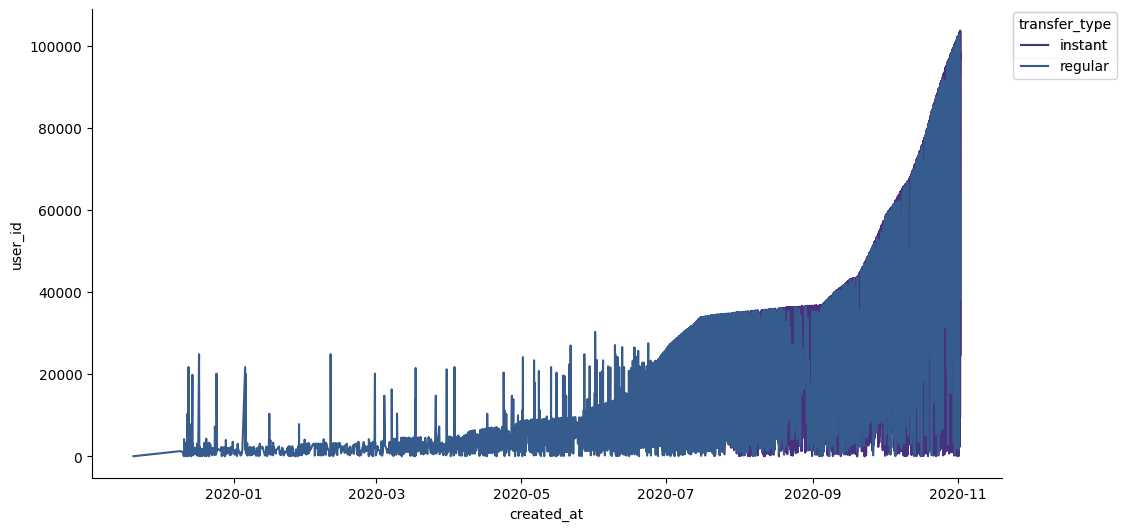

In [ ]:
# @title created_at vs id_completo

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('viridis'))
  xs = series['created_at']
  ys = series['id_completo']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cr.sort_values('created_at', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('transfer_type')):
  _plot_series(series, series_name, i)
  fig.legend(title='transfer_type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('created_at')
_ = plt.ylabel('id_completo')

In [ ]:
# Crear columna 'Cohorte' que indica el mes de la primera solicitud de cada cliente
cr['Cohorte'] = cr.groupby('id_completo')['created_at'].transform('min').dt.to_period('M')
cr.head(10)

,amount,created_at,user_id,transfer_type,Mes,Cohorte
0,100.0,2019-12-10 19:05:21.596873,804.0,regular,2019-12,2019-12
1,100.0,2019-12-10 19:50:12.347780,231.0,regular,2019-12,2019-12
2,100.0,2019-12-10 19:13:35.825460,191.0,regular,2019-12,2019-12
3,99.0,2019-12-10 19:16:10.880172,761.0,regular,2019-12,2019-12
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular,2020-05,2020-05
5,100.0,2020-05-23 20:58:55.129432,9489.0,regular,2020-05,2020-05
6,100.0,2020-06-16 17:07:38.452652,14631.0,regular,2020-06,2020-06
7,100.0,2020-02-10 01:11:53.808270,309.0,regular,2020-02,2020-01
8,100.0,2020-06-28 12:06:33.712840,2499.0,regular,2020-06,2020-06
9,90.0,2019-12-10 19:51:23.911206,897.0,regular,2019-12,2019-12


In [ ]:
# Calcular el número inicial de clientes únicos en cada cohorte
cohort_sizes_initial = cr.groupby('Cohorte').agg(Num_Clientes_Iniciales=('id_completo', 'nunique')).reset_index()
cohort_sizes_initial

,Cohorte,Num_Clientes_Iniciales
0,2019-11,1
1,2019-12,254
2,2020-01,106
3,2020-02,90
4,2020-03,86
5,2020-04,246
6,2020-05,432
7,2020-06,1540
8,2020-07,1482
9,2020-08,728


In [ ]:
# Calcular la cantidad de clientes únicos en cada cohorte para cada mes
cohort_sizes_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_Clientes=('id_completo', 'nunique')).reset_index()
cohort_sizes_monthly

,Cohorte,Mes,Num_Clientes
0,2019-11,2019-11,1
1,2019-11,2019-12,1
2,2019-11,2020-04,1
3,2019-11,2020-05,1
4,2019-11,2020-08,1
...,...,...,...
78,2020-09,2020-10,680
79,2020-09,2020-11,20
80,2020-10,2020-10,4802
81,2020-10,2020-11,15


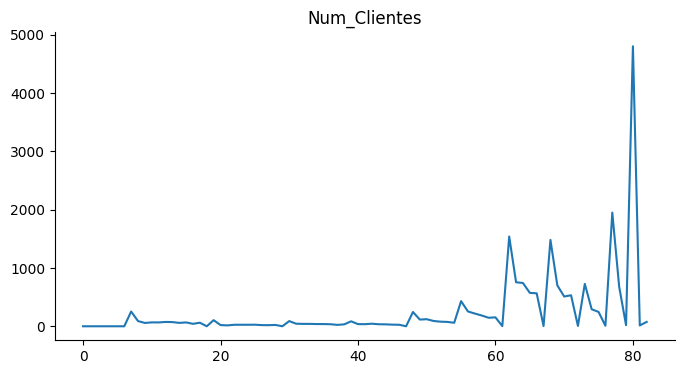

In [ ]:
# @title Num_Clientes

from matplotlib import pyplot as plt
cohort_sizes_monthly['Num_Clientes'].plot(kind='line', figsize=(8, 4), title='Num_Clientes')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# Calcular la cantidad de solicitudes de adelanto de efectivo de los clientes de cada cohorte en cada mes
cohort_cash_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_Solicitudes=('id_completo', 'count')).reset_index()
cohort_cash_monthly

,Cohorte,Mes,Num_Solicitudes
0,2019-11,2019-11,1
1,2019-11,2019-12,1
2,2019-11,2020-04,1
3,2019-11,2020-05,1
4,2019-11,2020-08,1
...,...,...,...
78,2020-09,2020-10,727
79,2020-09,2020-11,20
80,2020-10,2020-10,5043
81,2020-10,2020-11,15


In [ ]:
# Calcular la tasa de retención de clientes (clientes únicos por cohorte en cada mes / clientes iniciales de la cohorte)
retention_clientes = cohort_sizes_monthly.pivot(index='Cohorte', columns='Mes', values='Num_Clientes')
retention_clientes = retention_clientes.div(cohort_sizes_initial.set_index('Cohorte')['Num_Clientes_Iniciales'], axis=0)
retention_clientes

Mes,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,,,,,,,
2019-11,1.0,1.0,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.000000,1.000000,NaN
2019-12,NaN,1.0,0.354331,0.228346,0.267717,0.263780,0.295276,0.287402,0.232283,0.263780,0.169291,0.244094,0.003937
2020-01,NaN,NaN,1.000000,0.207547,0.150943,0.254717,0.254717,0.254717,0.264151,0.198113,0.188679,0.226415,0.009434
2020-02,NaN,NaN,NaN,1.000000,0.500000,0.466667,0.466667,0.433333,0.433333,0.400000,0.277778,0.377778,NaN
2020-03,NaN,NaN,NaN,NaN,1.000000,0.441860,0.430233,0.523256,0.418605,0.395349,0.337209,0.313953,0.011628
2020-04,NaN,NaN,NaN,NaN,NaN,1.000000,0.471545,0.495935,0.373984,0.325203,0.308943,0.247967,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.590278,0.506944,0.430556,0.340278,0.356481,0.009259
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.490909,0.482468,0.372727,0.367532,0.003247
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.474359,0.344804,0.359649,0.004723


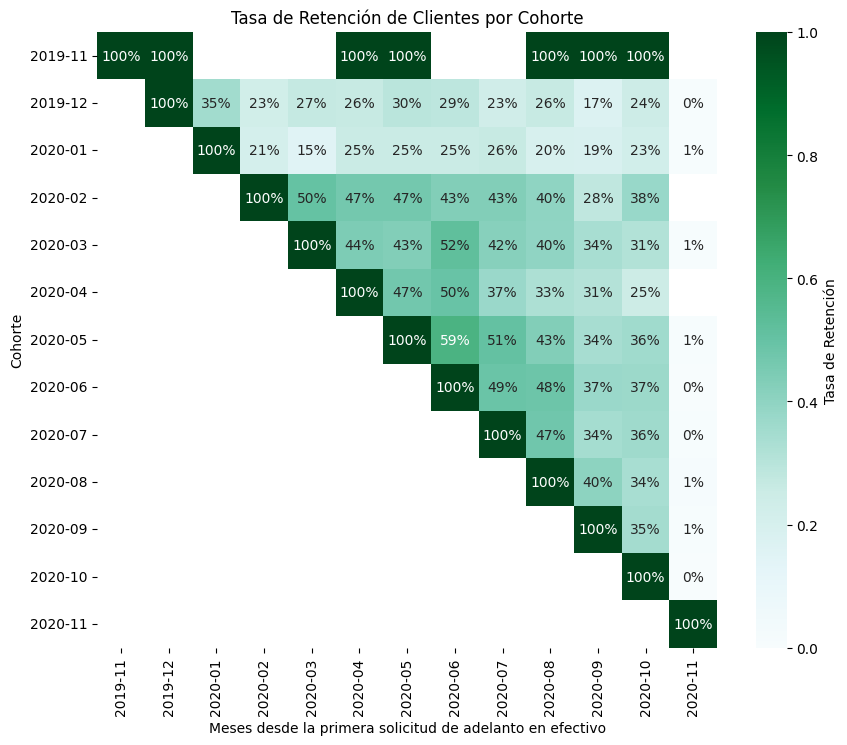

In [ ]:
# Visualizar la tasa de retención de clientes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Retención de Clientes por Cohorte')
sns.heatmap(data=retention_clientes, annot=True, fmt='.0%', vmin=0.0, vmax=1.0, +
            cmap='BuGn', cbar_kws={'label': 'Tasa de Retención'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')
plt.show()

In [ ]:
# Calcular la tasa de abandono de clientes (1- tasa de retención)
churn_clientes = 1- retention_clientes

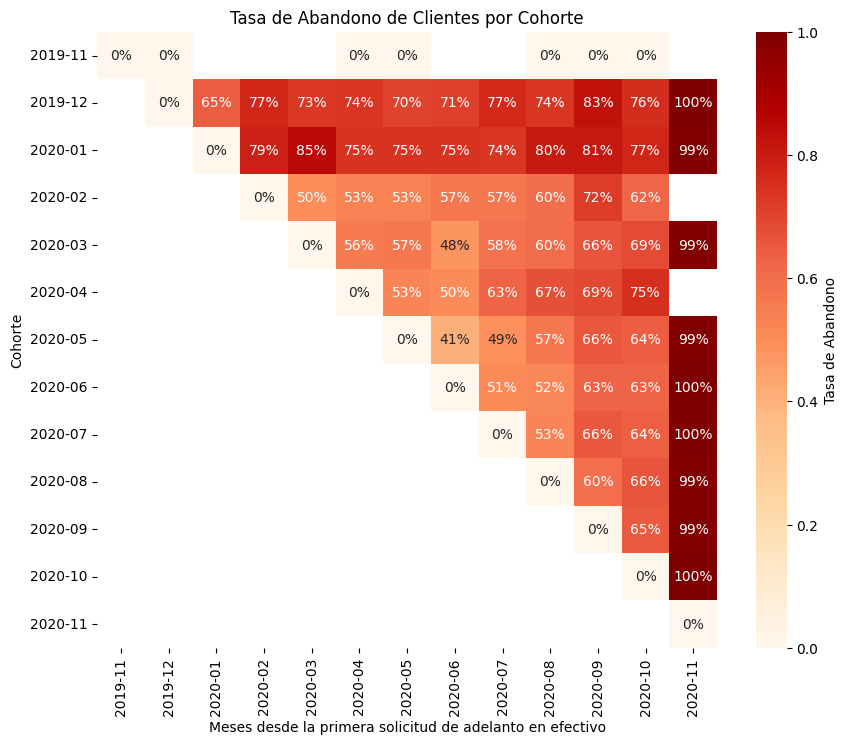

In [ ]:
# Visualizar la tasa de abandono de clientes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Abandono de Clientes por Cohorte')
sns.heatmap(data=churn_clientes, annot=True, fmt='.0%', vmin=0.0, vmax=1.0, cmap='OrRd', cbar_kws={'label': 'Tasa de Abandono'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')
plt.show()

In [ ]:
# Calcular el número inicial de solicitudes de adelanto de efectivo en cada cohorte
cohort_cash_initial = cohort_cash_monthly.groupby('Cohorte').first().reset_index().rename(columns={'Num_Solicitudes': 'Num_Solicitudes_Iniciales'})
cohort_cash_initial

,Cohorte,Mes,Num_Solicitudes_Iniciales
0,2019-11,2019-11,1
1,2019-12,2019-12,288
2,2020-01,2020-01,117
3,2020-02,2020-02,97
4,2020-03,2020-03,99
5,2020-04,2020-04,264
6,2020-05,2020-05,478
7,2020-06,2020-06,1934
8,2020-07,2020-07,1996
9,2020-08,2020-08,993


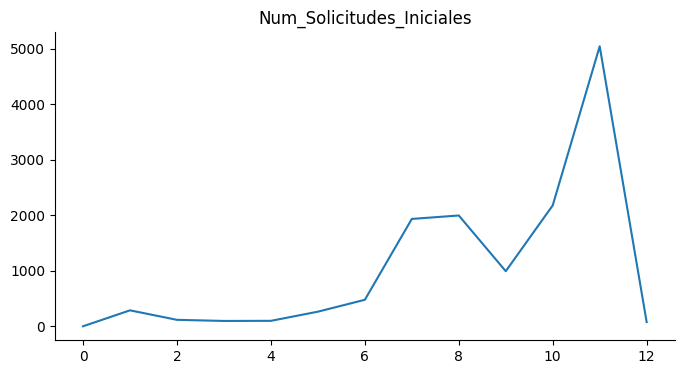

In [ ]:
# @title Numero de Solicitudes Iniciales en cada cohorte

from matplotlib import pyplot as plt
cohort_cash_initial['Num_Solicitudes_Iniciales'].plot(kind='line', figsize=(8, 4), title='Num_Solicitudes_Iniciales')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# @title Calcular la tasa de retención de solicitudes (solicitudes por cohorte en cada mes / solicitudes iniciales de la cohorte)
retention_cash = cohort_cash_monthly.pivot(index='Cohorte', columns='Mes', values='Num_Solicitudes')
retention_cash = retention_cash.div(cohort_cash_initial.set_index('Cohorte')['Num_Solicitudes_Iniciales'], axis=0)
retention_cash

Mes,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,,,,,,,
2019-11,1.0,1.0,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.000000,2.000000,NaN
2019-12,NaN,1.0,0.368056,0.218750,0.274306,0.284722,0.298611,0.315972,0.250000,0.291667,0.184028,0.260417,0.003472
2020-01,NaN,NaN,1.000000,0.205128,0.145299,0.299145,0.264957,0.247863,0.264957,0.188034,0.188034,0.213675,0.008547
2020-02,NaN,NaN,NaN,1.000000,0.505155,0.505155,0.463918,0.463918,0.463918,0.453608,0.278351,0.412371,NaN
2020-03,NaN,NaN,NaN,NaN,1.000000,0.424242,0.464646,0.474747,0.404040,0.363636,0.303030,0.303030,0.010101
2020-04,NaN,NaN,NaN,NaN,NaN,1.000000,0.568182,0.571970,0.439394,0.405303,0.337121,0.284091,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.665272,0.573222,0.485356,0.376569,0.364017,0.008368
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.531024,0.494829,0.355222,0.339193,0.002585
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.471443,0.304609,0.298096,0.003507


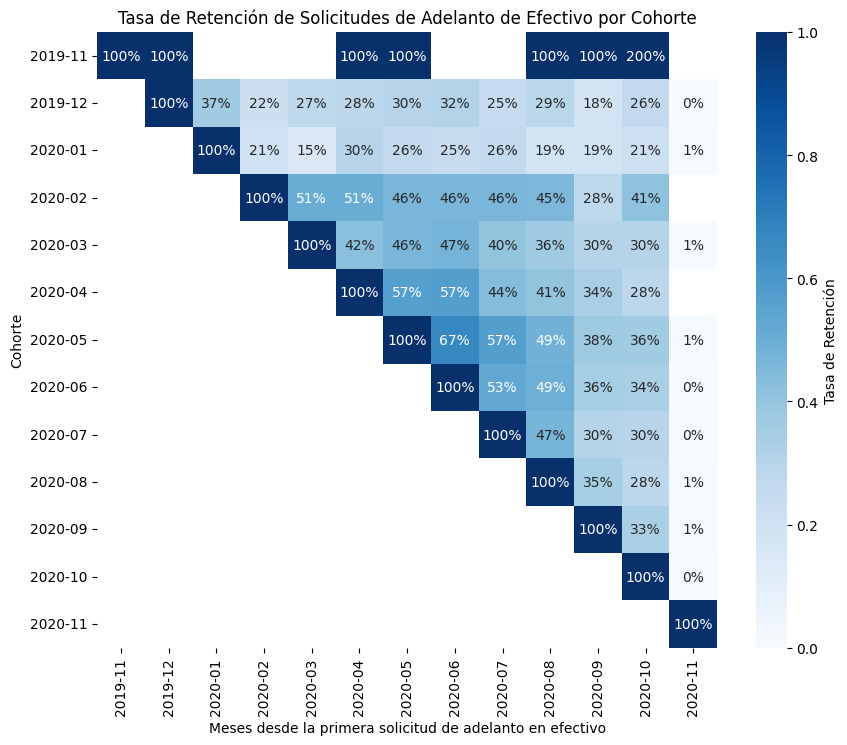

In [ ]:
# Visualizar la tasa de retención de solicitudes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Retención de Solicitudes de Adelanto de Efectivo por Cohorte')
sns.heatmap(data=retention_cash, annot=True, fmt='.0%', vmin=0.0, vmax=1.0, cmap='Blues', cbar_kws={'label': 'Tasa de Retención'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')
plt.show()

In [ ]:
# Calcular la tasa de abandono de solicitudes (1- tasa de retención de solicitudes)
churn_cash = 1- retention_cash
churn_cash

Mes,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,,,,,,,
2019-11,0.0,0.0,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,-1.000000,NaN
2019-12,NaN,0.0,0.631944,0.781250,0.725694,0.715278,0.701389,0.684028,0.750000,0.708333,0.815972,0.739583,0.996528
2020-01,NaN,NaN,0.000000,0.794872,0.854701,0.700855,0.735043,0.752137,0.735043,0.811966,0.811966,0.786325,0.991453
2020-02,NaN,NaN,NaN,0.000000,0.494845,0.494845,0.536082,0.536082,0.536082,0.546392,0.721649,0.587629,NaN
2020-03,NaN,NaN,NaN,NaN,0.000000,0.575758,0.535354,0.525253,0.595960,0.636364,0.696970,0.696970,0.989899
2020-04,NaN,NaN,NaN,NaN,NaN,0.000000,0.431818,0.428030,0.560606,0.594697,0.662879,0.715909,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.334728,0.426778,0.514644,0.623431,0.635983,0.991632
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.468976,0.505171,0.644778,0.660807,0.997415
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.528557,0.695391,0.701904,0.996493


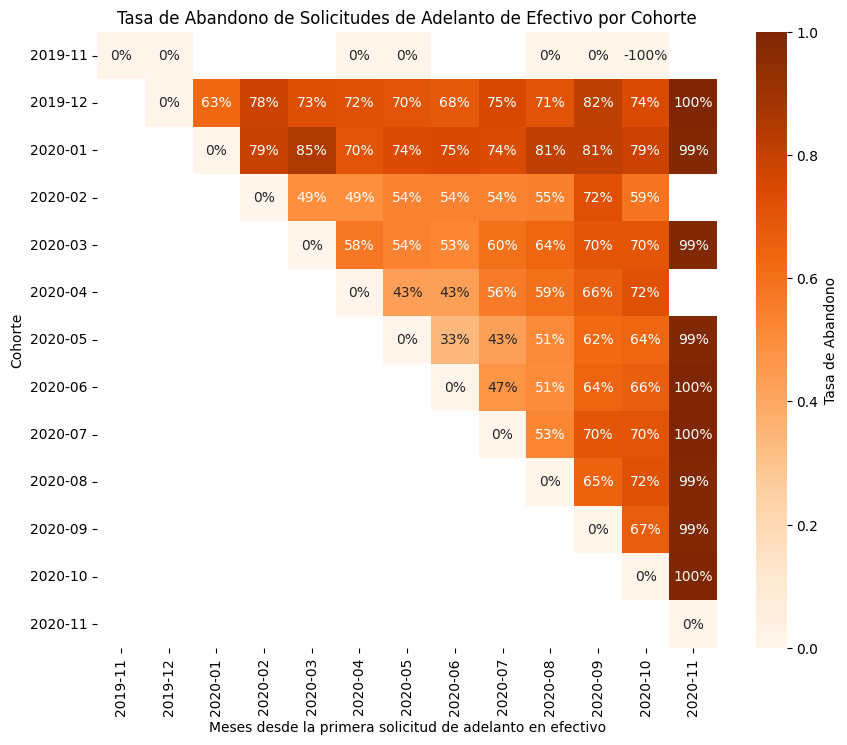

In [ ]:
# Visualizar la tasa de abandono de solicitudes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Abandono de Solicitudes de Adelanto de Efectivo por Cohorte')
sns.heatmap(data=churn_cash, annot=True, fmt='.0%', vmin=0.0, vmax=1.0, cmap='Oranges', cbar_kws={'label': 'Tasa de Abandono'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')
plt.show()

# **2A PARTE**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
def evaluate_regression_models(df,feature_col, target_col, poly_degrees=[1, 2, 3, 4, 5], alpha_values=[0.001, 0.01, 0.1, 1, 1.1, 1.5, 2],
                              n_splits=5, random_state=42, test_size=0.2, extrapolation_size=0.2, l1_ratio=0.5, polynomial_features=1):
    """
    Evaluate Ridge, Lasso, ElasticNet, and Linear Regression models with polynomial features.
    Includes 95% confidence intervals in the plots.

    Parameters:
    - X: numpy array, feature data (n_samples, n_features)
    - y: numpy array, target data (n_samples,)
    - poly_degrees: list, polynomial degrees to test
    - alpha_values: list, regularization strengths for Ridge, Lasso, and ElasticNet
    - n_splits: int, number of folds for cross-validation
    - random_state: int, random seed for reproducibility
    - test_size: float, proportion of the dataset to include in the test split
    - extrapolation_size: float, proportion of the dataset to include in the extrapolation split
    - l1_ratio: float, the mixing parameter for ElasticNet (0 <= l1_ratio <= 1)
    - polynomial_features: int, the parameter for creating Polynomial Features
    Returns:
    - None (plots and prints evaluation metrics)
    """
     # Remove NaN values
    df_train = df.dropna()

    if polynomial_features > 1:
        poly = PolynomialFeatures(degree=polynomial_features, include_bias=False)
        X_poly = poly.fit_transform(df_train[[feature_col]])
        X = np.array(X_poly)  # No need to reshape as fit_transform already returns a 2D array
    else:
        X = np.array(df_train[[feature_col]])  # No need for reshaping, already 2D

    # Convert target variable to numpy array
    y = np.array(df_train[target_col])

    # Split dataset into interpolation and extrapolation sets
    X_interp, X_extrap, y_interp, y_extrap = train_test_split(X, y, test_size=extrapolation_size,
                                                              random_state=random_state, shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=test_size,
                                                        shuffle=True, random_state=random_state)


    # K-Fold Cross Validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Loop through each polynomial degree
    for degree in poly_degrees:
        best_ridge_alpha, best_lasso_alpha, best_elastic_alpha = None, None, None
        best_ridge_model, best_lasso_model, best_elastic_model, best_linear_model = None, None, None, None
        best_ridge_mse, best_lasso_mse, best_elastic_mse, best_linear_mse = float('inf'), float('inf'), float('inf'), float('inf')

        # Loop through different alpha values for Ridge, Lasso, and ElasticNet
        for alpha in alpha_values:
            # Ridge Regression
            ridge_model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
            ridge_preds = cross_val_predict(ridge_model, X_train, y_train, cv=kf)
            ridge_mse = mean_squared_error(y_train, ridge_preds)

            if ridge_mse < best_ridge_mse:
                best_ridge_mse = ridge_mse
                best_ridge_alpha = alpha
                best_ridge_model = ridge_model

            # Lasso Regression
            lasso_model = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha, max_iter=10000))
            lasso_preds = cross_val_predict(lasso_model, X_train, y_train, cv=kf)
            lasso_mse = mean_squared_error(y_train, lasso_preds)

            if lasso_mse < best_lasso_mse:
                best_lasso_mse = lasso_mse
                best_lasso_alpha = alpha
                best_lasso_model = lasso_model

            # ElasticNet Regression
            elastic_model = make_pipeline(PolynomialFeatures(degree), ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000))
            elastic_preds = cross_val_predict(elastic_model, X_train, y_train, cv=kf)
            elastic_mse = mean_squared_error(y_train, elastic_preds)

            if elastic_mse < best_elastic_mse:
                best_elastic_mse = elastic_mse
                best_elastic_alpha = alpha
                best_elastic_model = elastic_model

        # Linear Regression (No Regularization)
        linear_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        linear_preds = cross_val_predict(linear_model, X_train, y_train, cv=kf)
        best_linear_mse = mean_squared_error(y_train, linear_preds)
        best_linear_model = linear_model

        # Train the best models for this degree
        best_ridge_model.fit(X_interp, y_interp)
        best_lasso_model.fit(X_interp, y_interp)
        best_elastic_model.fit(X_interp, y_interp)
        best_linear_model.fit(X_interp, y_interp)

        # Predictions
        ridge_y_predict_interp = best_ridge_model.predict(X_interp)
        ridge_y_predict_extra = best_ridge_model.predict(X_extrap)
        lasso_y_predict_interp = best_lasso_model.predict(X_interp)
        lasso_y_predict_extra = best_lasso_model.predict(X_extrap)
        elastic_y_predict_interp = best_elastic_model.predict(X_interp)
        elastic_y_predict_extra = best_elastic_model.predict(X_extrap)
        linear_y_predict_interp = best_linear_model.predict(X_interp)
        linear_y_predict_extra = best_linear_model.predict(X_extrap)

        # Compute residuals for confidence intervals
        ridge_residuals = y_interp - ridge_y_predict_interp
        lasso_residuals = y_interp - lasso_y_predict_interp
        elastic_residuals = y_interp - elastic_y_predict_interp
        linear_residuals = y_interp - linear_y_predict_interp

        # Standard deviation of residuals
        ridge_std = np.std(ridge_residuals)
        lasso_std = np.std(lasso_residuals)
        elastic_std = np.std(elastic_residuals)
        linear_std = np.std(linear_residuals)

        # 95% confidence interval (1.96 * std)
        ridge_ci = 1.96 * ridge_std
        lasso_ci = 1.96 * lasso_std
        elastic_ci = 1.96 * elastic_std
        linear_ci = 1.96 * linear_std

        # Compute R² Scores for Extrapolation
        R2_ridge_extrap = r2_score(y_extrap, ridge_y_predict_extra)
        R2_lasso_extrap = r2_score(y_extrap, lasso_y_predict_extra)
        R2_elastic_extrap = r2_score(y_extrap, elastic_y_predict_extra)
        R2_linear_extrap = r2_score(y_extrap, linear_y_predict_extra)

        # Plot Results
        plt.figure(figsize=(24, 5))

        # Ridge Plot
        plt.subplot(1, 4, 1)
        plt.scatter(X_train[:,0].flatten(), y_train, label='Train', color='blue', alpha=0.5)
        plt.scatter(X_test[:,0].flatten(), y_test, label='Test', color='green', alpha=0.5)
        plt.scatter(X_extrap[:,0].flatten(), y_extrap, label='Extrapolation', color='orange', alpha=0.5)
        plt.plot(X_interp[:,0].flatten(), ridge_y_predict_interp, label='Ridge (Interp)', color='red', linewidth=2)
        plt.fill_between(X_interp[:,0].flatten(), ridge_y_predict_interp - ridge_ci, ridge_y_predict_interp + ridge_ci,
                         color='red', alpha=0.2, label='95% CI')
        plt.plot(X_extrap[:,0].flatten(), ridge_y_predict_extra, label='Ridge (Extrap)', color='gray', linewidth=2)
        plt.fill_between(X_extrap[:,0].flatten(), ridge_y_predict_extra - ridge_ci, ridge_y_predict_extra + ridge_ci,
                         color='gray', alpha=0.2)
        plt.title(f'Ridge (Degree {degree}, α={best_ridge_alpha})')
        plt.legend()

        # Lasso Plot
        plt.subplot(1, 4, 2)
        plt.scatter(X_train[:,0].flatten(), y_train, label='Train', color='blue', alpha=0.5)
        plt.scatter(X_test[:,0].flatten(), y_test, label='Test', color='green', alpha=0.5)
        plt.scatter(X_extrap[:,0].flatten(), y_extrap, label='Extrapolation', color='orange', alpha=0.5)
        plt.plot(X_interp[:,0].flatten(), lasso_y_predict_interp, label='Lasso (Interp)', color='red', linewidth=2)
        plt.fill_between(X_interp[:,0].flatten(), lasso_y_predict_interp - lasso_ci, lasso_y_predict_interp + lasso_ci,
                         color='red', alpha=0.2, label='95% CI')
        plt.plot(X_extrap[:,0].flatten(), lasso_y_predict_extra, label='Lasso (Extrap)', color='gray', linewidth=2)
        plt.fill_between(X_extrap[:,0].flatten(), lasso_y_predict_extra - lasso_ci, lasso_y_predict_extra + lasso_ci,
                         color='gray', alpha=0.2)
        plt.title(f'Lasso (Degree {degree}, α={best_lasso_alpha})')
        plt.legend()

        # ElasticNet Plot
        plt.subplot(1, 4, 3)
        plt.scatter(X_train[:,0].flatten(), y_train, label='Train', color='blue', alpha=0.5)
        plt.scatter(X_test[:,0].flatten(), y_test, label='Test', color='green', alpha=0.5)
        plt.scatter(X_extrap[:,0].flatten(), y_extrap, label='Extrapolation', color='orange', alpha=0.5)
        plt.plot(X_interp[:,0].flatten(), elastic_y_predict_interp, label='ElasticNet (Interp)', color='red', linewidth=2)
        plt.fill_between(X_interp[:,0].flatten(), elastic_y_predict_interp - elastic_ci, elastic_y_predict_interp + elastic_ci,
                         color='red', alpha=0.2, label='95% CI')
        plt.plot(X_extrap[:,0].flatten(), elastic_y_predict_extra, label='ElasticNet (Extrap)', color='gray', linewidth=2)
        plt.fill_between(X_extrap[:,0].flatten().ravel(), elastic_y_predict_extra - elastic_ci, elastic_y_predict_extra + elastic_ci,
                         color='gray', alpha=0.2)
        plt.title(f'ElasticNet (Degree {degree}, α={best_elastic_alpha})')
        plt.legend()

        # Linear Regression Plot
        plt.subplot(1, 4, 4)
        plt.scatter(X_train[:,0].flatten(), y_train, label='Train', color='blue', alpha=0.5)
        plt.scatter(X_test[:,0].flatten(), y_test, label='Test', color='green', alpha=0.5)
        plt.scatter(X_extrap[:,0].flatten(), y_extrap, label='Extrapolation', color='orange', alpha=0.5)
        plt.plot(X_interp[:,0].flatten(), linear_y_predict_interp, label='Linear (Interp)', color='red', linewidth=2)
        plt.fill_between(X_interp[:,0].flatten().ravel(), linear_y_predict_interp - linear_ci, linear_y_predict_interp + linear_ci,
                         color='red', alpha=0.2, label='95% CI')
        plt.plot(X_extrap[:,0].flatten(), linear_y_predict_extra, label='Linear (Extrap)', color='gray', linewidth=2)
        plt.fill_between(X_extrap[:,0].flatten(), linear_y_predict_extra - linear_ci, linear_y_predict_extra + linear_ci,
                         color='gray', alpha=0.2)
        plt.title(f'Linear Regression (Degree {degree})')
        plt.legend()

        plt.tight_layout()
        plt.show()

        print(f"Degree {degree}:")
        print(f"  Ridge (α={best_ridge_alpha}, MSE={best_ridge_mse:.4f}), R² Extrapolation={R2_ridge_extrap:.4f}")
        print(f"  Lasso (α={best_lasso_alpha}, MSE={best_lasso_mse:.4f}), R² Extrapolation={R2_lasso_extrap:.4f}")
        print(f"  ElasticNet (α={best_elastic_alpha},l1_Ratio={l1_ratio} ,MSE={best_elastic_mse:.4f}), R² Extrapolation={R2_elastic_extrap:.4f}")
        print(f"  Linear Regression (MSE={best_linear_mse:.4f}), R² Extrapolation={R2_linear_extrap:.4f}")
        print()

## 2A

In [ ]:
def evaluate_polynomial_linear_regression(df, feature_col, target_col, poly_degrees=[1, 2, 3, 4, 5],
                                         test_size=0.2, extrapolation_size=0.2, random_state=42 , polynomial_features=1):

    """
    Evaluate Polynomial Linear Regression models with confidence intervals.

    Parameters:
    - df: pandas DataFrame, the dataset containing the feature and target columns.
    - feature_col: str, the name of the feature column.
    - target_col: str, the name of the target column.
    - poly_degrees: list, polynomial degrees to test.
    - test_size: float, proportion of the dataset to include in the test split.
    - extrapolation_size: float, proportion of the dataset to include in the extrapolation split.
    - random_state: int, random seed for reproducibility.

    Returns:
    - None (plots and prints evaluation metrics).
    """

    # Remove NaN values
    df_train = df.dropna()

    # Create Polynomial Features
    if polynomial_features > 1:
        poly = PolynomialFeatures(degree=polynomial_features, include_bias=False)
        X_poly = poly.fit_transform(df_train[[feature_col]])
        X = np.array(X_poly)
    else:
        X = np.array(df_train[[feature_col]])

    # Convert target variable to numpy array
    y = np.array(df_train[target_col])


    # Split dataset into interpolation and extrapolation sets
    X_interp, X_extrap, y_interp, y_extrap = train_test_split(X, y, test_size=extrapolation_size,
                                                              random_state=random_state, shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=test_size,
                                                        shuffle=True, random_state=random_state)

    # Loop through each polynomial degree
    for degree in poly_degrees:
        # Create and fit the Linear Regression Model with Polynomial Features
        linear_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        linear_model.fit(X_train, y_train)  # Train model

        # Predictions
        linear_train_preds = linear_model.predict(X_train)
        linear_test_preds = linear_model.predict(X_test)
        linear_y_predict_interp = linear_model.predict(X_interp)
        linear_y_predict_extra = linear_model.predict(X_extrap)

        # Compute Standard Deviation of Prediction Errors
        linear_std = np.std(y_train - linear_train_preds)

        # Compute Performance Metrics
        linear_mse_train = mean_squared_error(y_train, linear_train_preds)
        linear_mse_test = mean_squared_error(y_test, linear_test_preds)
        R2_sklearn_train = r2_score(y_train, linear_train_preds)
        R2_sklearn_test = r2_score(y_test, linear_test_preds)
        R2_sklearn_extrap = r2_score(y_extrap, linear_y_predict_extra)

        # Plot results for this degree
        plt.figure(figsize=(10, 6))
        print(X_train.shape,y_train.shape)
        plt.scatter(X_train[:,0].flatten(), y_train, label='Train (Interpolation)', color='blue', alpha=0.5)
        plt.scatter(X_test[:,0].flatten(), y_test, label='Test (Interpolation)', color='green', alpha=0.5)
        plt.scatter(X_extrap[:,0].flatten(), y_extrap, label='Extrapolation Real', color='orange', alpha=0.5)
        plt.plot(X_interp[:,0].flatten(), linear_y_predict_interp, label='Linear Trend (Interpolation)', color='red', linewidth=2)
        plt.plot(X_extrap[:,0].flatten(), linear_y_predict_extra, label='Linear Trend (Extrapolation)', color='gray', linewidth=2)

        # Add standard deviation bands
        plt.fill_between(X_interp[:,0].flatten(), linear_y_predict_interp - linear_std, linear_y_predict_interp + linear_std,
                         color='red', alpha=0.2, label='±1 Std Dev')
        plt.fill_between(X_extrap[:,0].flatten(), linear_y_predict_extra - linear_std, linear_y_predict_extra + linear_std,
                         color='gray', alpha=0.2)

        plt.title(f'Polynomial Linear Regression (Degree {degree})')
        plt.xlabel(feature_col)
        plt.ylabel(target_col)
        plt.legend()
        plt.show()

        # Print Performance Metrics
        print(f"Degree {degree}:")
        print(f" - Train MSE: {linear_mse_train:.4f}")
        print(f" - Test MSE: {linear_mse_test:.4f}")
        print(f" - R² Score (Train): {R2_sklearn_train:.4f}")
        print(f" - R² Score (Test): {R2_sklearn_test:.4f}")
        print(f" - R² Score (Extrapolation): {R2_sklearn_extrap:.4f}")
        print("=" * 60)

## **Cohorte inicio 2019-12**

In [ ]:
cohort_2019_12 = retention_request.loc['2019-12']  # Keep double brackets to retain DataFrame structure


df = cohort_2019_12.reset_index()  # Select first two columns dynamically
df.columns = ['Month', 'Retention_Rate']
df = df.iloc[:-1]
# Convert 'Month' from Period to datetime
df['Month'] = df['Month'].astype(str)  # Convert to string
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

# Convert 'Fecha_Compra' to numerical values (months since first purchase)
df['Month_Num'] = (df['Month'] - df['Month'].min()).dt.days // 30

df

In [ ]:
evaluate_polynomial_linear_regression(df,'Month_Num','Retention_Rate',polynomial_features=2)

## **Cohorte inicio 2020-01**

In [ ]:
cohort_2020_01 = retention_request.loc['2020-01']
df_2020_01 = cohort_2020_01.reset_index()

df_2020_01.columns = ['Month', 'Retention_Rate']
df_2020_01 = df_2020_01.iloc[:-1]
# Convert 'Month' from Period to datetime
df_2020_01['Month'] = df_2020_01['Month'].astype(str)  # Convert to string
df_2020_01['Month'] = pd.to_datetime(df_2020_01['Month'], format='%Y-%m')

# Convert 'Fecha_Compra' to numerical values (months since first purchase)
df_2020_01['Month_Num'] = (df_2020_01['Month'] - df_2020_01['Month'].min()).dt.days // 30

df_2020_01

In [ ]:
evaluate_polynomial_linear_regression(df_2020_01,'Month_Num','Retention_Rate')

## **Cohorte inicio 2020-02**

In [ ]:
cohort_2020_02 = retention_request.loc['2020-02']
df_2020_02 = cohort_2020_02.reset_index()

df_2020_02.columns = ['Month', 'Retention_Rate']
df_2020_02 = df_2020_02.iloc[:-1]
# Convert 'Month' from Period to datetime
df_2020_02['Month'] = df_2020_02['Month'].astype(str)  # Convert to string
df_2020_02['Month'] = pd.to_datetime(df_2020_02['Month'], format='%Y-%m')

# Convert 'Fecha_Compra' to numerical values (months since first purchase)
df_2020_02['Month_Num'] = (df_2020_02['Month'] - df_2020_02['Month'].min()).dt.days // 30
df_2020_02['Month_Num'] = df_2020_02['Month_Num'].astype(int)
df_2020_02

In [ ]:
evaluate_polynomial_linear_regression(df_2020_02,'Month_Num','Retention_Rate')

In [ ]:
# Merge datasets using cash_request_id from fees and id from cash_request
merged_df = fees.merge(cash_request, left_on='cash_request_id', right_on='id', how='inner')

# Drop redundant columns (ensure 'id_y' exists before dropping)
if 'id_y' in merged_df.columns:
    merged_df = merged_df.drop(columns=["id_y"])

# Rename columns for clarity
merged_df.rename(columns={"id_x": "fee_id", "cash_request_id": "cash_request_id"}, inplace=True)

#  Correct Column Naming
if 'created_at_y' in merged_df.columns:  # Prefer cash request date
    merged_df['created_at_cash_request'] = merged_df['created_at_y']
    merged_df = merged_df.drop(columns=["created_at_y"])
    if 'created_at_x' in merged_df.columns:  # Use fee date if cash request date is missing
        merged_df['created_at_fees'] = merged_df['created_at_x']
        merged_df = merged_df.drop(columns=["created_at_x"])
else:
    raise KeyError("Column 'created_at' not found in merged dataset")

#  Convert 'created_at_cash_request' to datetime
merged_df['created_at_cash_request'] = pd.to_datetime(merged_df['created_at_cash_request'], errors='coerce')

#  Create Month Column for Cash Request
merged_df['Month_cash_request'] = merged_df['created_at_cash_request'].dt.to_period('M')
merged_df['Month_cash_request'] = merged_df['Month_cash_request'].astype(str)  # Convert to string
merged_df['Month_cash_request'] = pd.to_datetime(merged_df['Month_cash_request'], format='%Y-%m')

merged_df['Month_Num_cash_request'] = ((merged_df['Month_cash_request'] - merged_df['Month_cash_request'].min()).dt.days // 30)

#  Convert 'created_at_fees' to datetime
merged_df['created_at_fees'] = pd.to_datetime(merged_df['created_at_fees'], errors='coerce')

#  Create Month Column for Fees
merged_df['Month_fees'] = merged_df['created_at_fees'].dt.to_period('M')
merged_df['Month_fees'] = merged_df['Month_fees'].astype(str)  # Convert to string
merged_df['Month_fees'] = pd.to_datetime(merged_df['Month_fees'], format='%Y-%m')

merged_df['Month_Num_fees'] = ((merged_df['Month_fees'] - merged_df['Month_fees'].min()).dt.days // 30)

#  Display the merged dataset info
merged_df.info()